In [1]:
from datasets import load_dataset
from huggingface_hub import list_datasets
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import cv2
import random
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
##ImageFolder and Dataloader from locally cloned repo
transform = transforms.Compose([
    transforms.Resize((224, 224)), ##resize 
    transforms.ToTensor() ##transform to tensor
])
train_dataset = ImageFolder(root='./data/brain-tumour-MRI-scan/Training', transform=transform)
loaded_train = DataLoader(train_dataset, batch_size=128, shuffle=True) 
##set batch size to 128 as in COVID paper

test_dataset = ImageFolder(root='./data/brain-tumour-MRI-scan/Testing', transform=transform)
loaded_test = DataLoader(test_dataset, batch_size=128, shuffle=False)

class_labels = test_dataset.classes
print("Classes:", class_labels)
print("\nTrain Shape:",train_dataset[0][0].shape,"\tTest Shape:", test_dataset[0][0].shape)
print("\nTrain Length:",len(train_dataset),"\tTest Length:", len(test_dataset))

Classes: ['1-notumor', '2-glioma', '3-meningioma', '4-pituitary']

Train Shape: torch.Size([3, 224, 224]) 	Test Shape: torch.Size([3, 224, 224])

Train Length: 5712 	Test Length: 1311


Text(0.5, 1.0, 'No tumor')

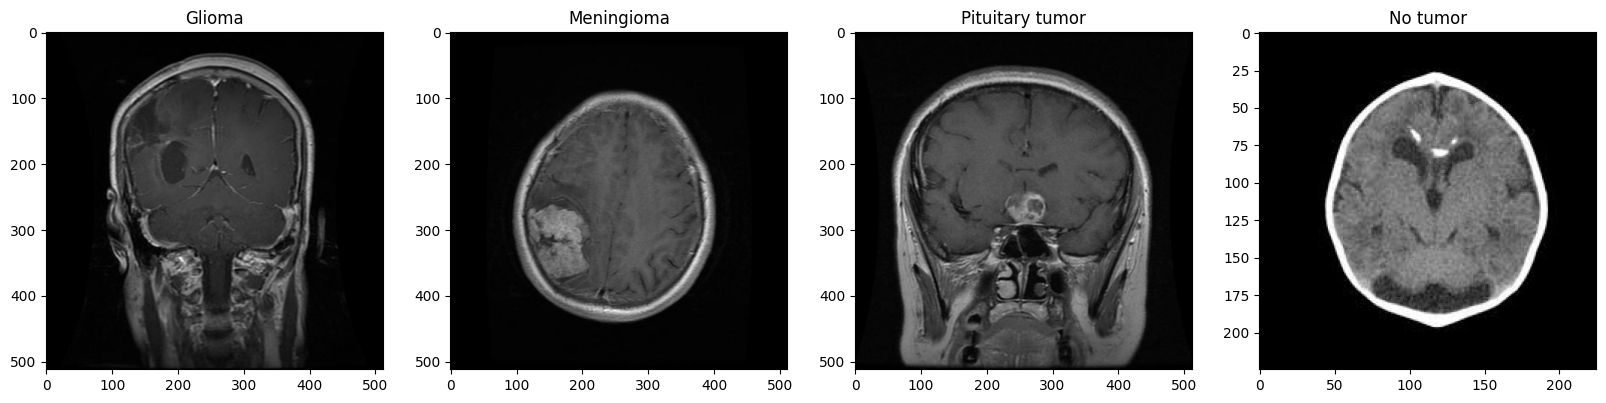

In [4]:
## Display images from the dataset on subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes = axes.flatten()
img1 = cv2.imread('data/brain-tumour-MRI-scan/Training/2-glioma/Tr-gl_0010.jpg')
axes[0].imshow(img1)
axes[0].set_title('Glioma')
img2 = cv2.imread('data/brain-tumour-MRI-scan/Training/3-meningioma/Tr-me_0010.jpg')
axes[1].imshow(img2)
axes[1].set_title('Meningioma')
img3 = cv2.imread('data/brain-tumour-MRI-scan/Training/4-pituitary/Tr-pi_0010.jpg')
axes[2].imshow(img3)
axes[2].set_title('Pituitary tumor')
img4 = cv2.imread('data/brain-tumour-MRI-scan/Training/1-notumor/Tr-no_0010.jpg')
axes[3].imshow(img4)
axes[3].set_title('No tumor')

In [5]:
type(train_dataset[0])

tuple

In [6]:
test_dataset[0][0][0][0]#[0]  ##4D tensor

tensor([0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0039, 0.0039, 0.0039, 

In [7]:
##visualise each class in each dataset
train_path = './data/brain-tumour-MRI-scan/Training'
test_path = './data/brain-tumour-MRI-scan/Testing'

def visualise_data(path):
    #find all folders in this dir
    folders = os.listdir(path)
    class_count = []
    for f in folders:
        #get all files in this folder
        all_files = os.listdir(path + '/' + f)
        #count number of files in each class folder
        #index = 0
        class_count.append(len(all_files))
        #index += 1

    ##bar plot of class distribution
    plt.bar(class_labels, class_count, color='blue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

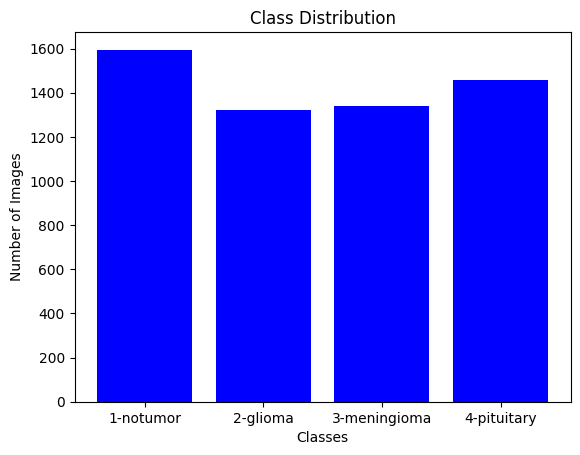

In [8]:
visualise_data(train_path)

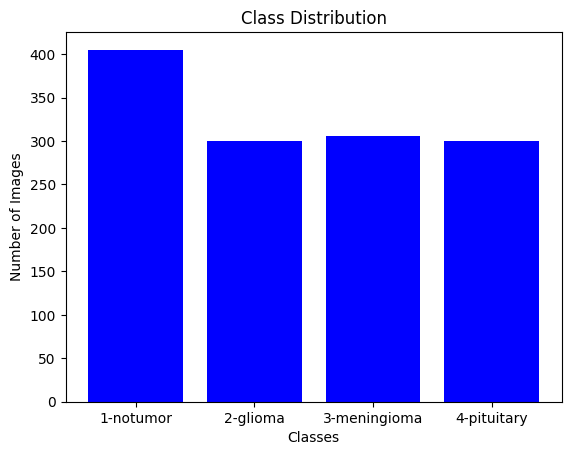

In [9]:
visualise_data(test_path)

In [4]:
##start autoencoder classes
##first layer autoencoder class
hidden_size = 5
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
##train on first autoencoder then plot loss
autoencoder_1 = Autoencoder1().to(device)
criterion_1_4 = nn.MSELoss()
optimizer = optim.Adam(autoencoder_1.parameters(), lr=0.001)

In [14]:
epochs = 500
def train_per_layer(train_dataloader, autoencoder, criterion, optimizer, epochs):#, threshold=0.5):
    loss_per_epoch = []
    #accuracy_per_epoch = []
    #recall_per_epoch = []
    for epoch in range(epochs):
        running_loss = 0.0
        features = []
        #running_accuracy = 0.0
        #running_recall = 0.0
        #total_samples = 0
        for data in train_dataloader:
            img, _ = data
            img = Variable(img).to(device)
            optimizer.zero_grad()
            output_features = autoencoder(img)
            loss = criterion(output_features, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        ##every epoch has its output features and plot the last one
        features.append(output_features)
        loss_per_epoch.append(running_loss/len(train_dataloader))
        print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_dataset)))
    return features, loss_per_epoch 

In [6]:
type(loaded_train)

torch.utils.data.dataloader.DataLoader

In [7]:
for epoch in range(10):  ##training 10 epochs due to response issues and time limit issues
    running_loss = 0.0
    for data in loaded_train:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder_1(img)
        loss = criterion_1_4(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_dataset)))

Epoch [1], Loss: 0.0003
Epoch [2], Loss: 0.0001
Epoch [3], Loss: 0.0001
Epoch [4], Loss: 0.0001
Epoch [5], Loss: 0.0001
Epoch [6], Loss: 0.0001
Epoch [7], Loss: 0.0001
Epoch [8], Loss: 0.0001
Epoch [9], Loss: 0.0001
Epoch [10], Loss: 0.0001


In [8]:
h1_features = outputs

In [9]:
h1_features ##plot

tensor([[[[0.0032, 0.0039, 0.0033,  ..., 0.0050, 0.0043, 0.0000],
          [0.0040, 0.0018, 0.0016,  ..., 0.0014, 0.0025, 0.0000],
          [0.0067, 0.0077, 0.0061,  ..., 0.0067, 0.0049, 0.0000],
          ...,
          [0.0092, 0.0114, 0.0096,  ..., 0.0120, 0.0000, 0.0000],
          [0.0062, 0.0070, 0.0073,  ..., 0.0059, 0.0054, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0025, 0.0000, 0.0022,  ..., 0.0000, 0.0033, 0.0000],
          [0.0000, 0.0095, 0.0000,  ..., 0.0092, 0.0000, 0.0000],
          [0.0062, 0.0018, 0.0050,  ..., 0.0000, 0.0038, 0.0000],
          ...,
          [0.0043, 0.0131, 0.0065,  ..., 0.0125, 0.0015, 0.0000],
          [0.0048, 0.0000, 0.0055,  ..., 0.0000, 0.0042, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0006]],

         [[0.0000, 0.0012, 0.0000,  ..., 0.0020, 0.0000, 0.0000],
          [0.0097, 0.0023, 0.0079,  ..., 0.0043, 0.0100, 0.0337],
          [0.0000, 0.0055, 0.0000,  ..., 0

In [10]:
torch.save(autoencoder_1.state_dict(), 'autoencoder_1.pth')
print("Autoencoder Layer 1 saved successfully.")

Autoencoder Layer 1 saved successfully.


In [12]:
autoencoder_1.eval()  # Set the model to evaluation mode

Autoencoder1(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
  )
)

In [8]:
def plot_4d_tensor(tensor, num_images=4, num_channels=3): ##plot first 4 images
    """
    Plot a 4D tensor by visualizing individual images and channels.
    
    Parameters:
    tensor (torch.Tensor): The 4D tensor to plot with shape [batch_size, channels, height, width].
    num_images (int): Number of images to plot from the batch.
    num_channels (int): Number of channels to plot from each image.
    """
    batch_size, channels, height, width = tensor.shape
    fig, axes = plt.subplots(num_images, num_channels, figsize=(num_channels * 3, num_images * 3))
    
    for i in range(num_images):
        for j in range(num_channels):
            if num_images == 1:
                ax = axes[j]
            elif num_channels == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]
            ax.imshow(tensor[i, j].detach().numpy(), cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Image {i+1}, Channel {j+1}')
    
    plt.tight_layout()
    plt.show()

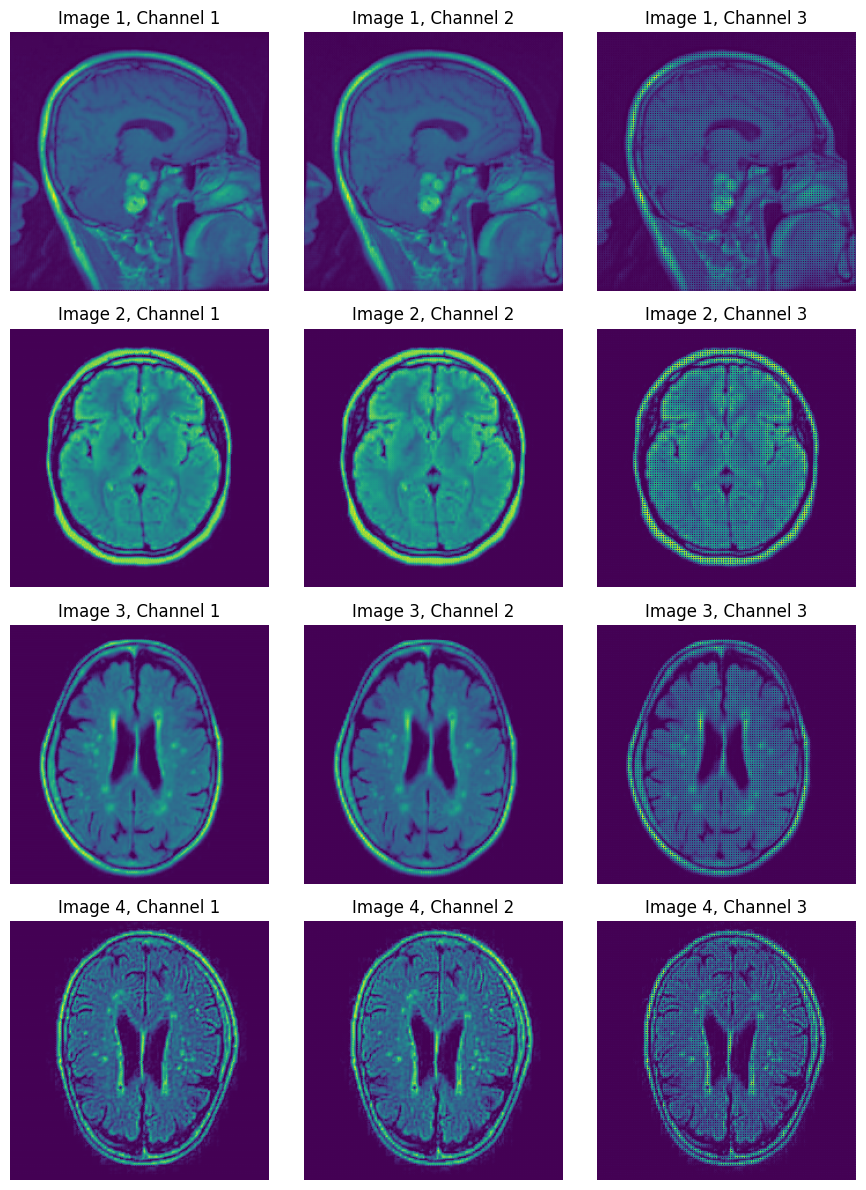

In [14]:
plot_4d_tensor(h1_features, num_images=4, num_channels=3)

Text(0.5, 1.0, 'Autoencoder layer 1 Loss')

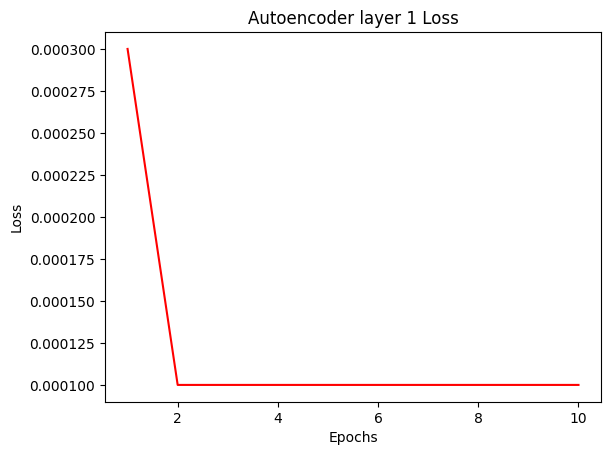

In [18]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
losses = [0.0003, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
plt.plot(epochs, losses, linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder layer 1 Loss')

In [19]:
###test
from sklearn.metrics import classification_report
autoencoder_1.eval()
for criteria in [0.0001,0.0003,0.001,0.003,0.01,0.03,0.1]:
    y_pred=[]
    y_true=[]  
    test_loss = 0.0
    with torch.no_grad():
        for data in loaded_test:
            img, label = data
            img = Variable(img).to(device)
            test_outputs = autoencoder_1(img)
            loss = criterion_1_4(test_outputs, img)
            test_loss += loss.item()
            for i in range(len(img)):
                lossi=criterion_1_4(test_outputs[i], img[i])
                y_pred+=[int(lossi.item()>criteria)] #true(big loss)=1,false(small loss)=0
                y_true+=[int(label[i]>0)] #true(not normal)=1,false(normal)=0
    print('test_loss',test_loss)
    print('criteria: lossi.item()>',criteria)
    print(classification_report(y_true, y_pred, target_names=['Normal','Abnormal'], digits=4))

test_loss 0.08148233965039253
criteria: lossi.item()> 0.0001


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.08148233965039253
criteria: lossi.item()> 0.0003


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.08148233965039253
criteria: lossi.item()> 0.001
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311



e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

test_loss 0.08148233965039253
criteria: lossi.item()> 0.003
              precision    recall  f1-score   support

      Normal     0.1064    0.0247    0.0401       405
    Abnormal     0.6754    0.9073    0.7744       906

    accuracy                         0.6346      1311
   macro avg     0.3909    0.4660    0.4072      1311
weighted avg     0.4996    0.6346    0.5475      1311

test_loss 0.08148233965039253
criteria: lossi.item()> 0.01
              precision    recall  f1-score   support

      Normal     0.2118    0.5481    0.3056       405
    Abnormal     0.3042    0.0883    0.1369       906

    accuracy                         0.2304      1311
   macro avg     0.2580    0.3182    0.2212      1311
weighted avg     0.2757    0.2304    0.1890      1311

test_loss 0.08148233965039253
criteria: lossi.item()> 0.03
              precision    recall  f1-score   support

      Normal     0.3076    0.9926    0.4696       405
    Abnormal     0.2500    0.0011    0.0022       906

    

e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.3089    1.0000    0.4720       405
    Abnormal     0.0000    0.0000    0.0000       906

    accuracy                         0.3089      1311
   macro avg     0.1545    0.5000    0.2360      1311
weighted avg     0.0954    0.3089    0.1458      1311



In [22]:
###autoencoder layer 2
##write a second Autoendocer class with the required parameters
##repeat until you get to 5th layer 
##THEN CREATE A STACKED AUTOENCODER CLASS WHERE YOU CREATE SEPARATE STACKED AUTOENCODER OBJECTS INSIDE
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
autoencoder_2 = Autoencoder2().to(device)
#criterion_1_4 = nn.MSELoss()
optimizer = optim.Adam(autoencoder_2.parameters(), lr=0.001)

In [24]:
for epoch in range(10):  ##training 10 epochs due to response issues and time limit issues
    running_loss = 0.0
    for data in loaded_train:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder_2(img)
        loss = criterion_1_4(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_dataset)))

Epoch [1], Loss: 0.0003
Epoch [2], Loss: 0.0001
Epoch [3], Loss: 0.0001
Epoch [4], Loss: 0.0001
Epoch [5], Loss: 0.0001
Epoch [6], Loss: 0.0001
Epoch [7], Loss: 0.0001
Epoch [8], Loss: 0.0001
Epoch [9], Loss: 0.0001
Epoch [10], Loss: 0.0001


In [25]:
h2_features = outputs

In [28]:
torch.save(autoencoder_2.state_dict(), 'autoencoder_2.pth')
print("Autoencoder Layer 2 saved successfully.")

Autoencoder Layer 2 saved successfully.


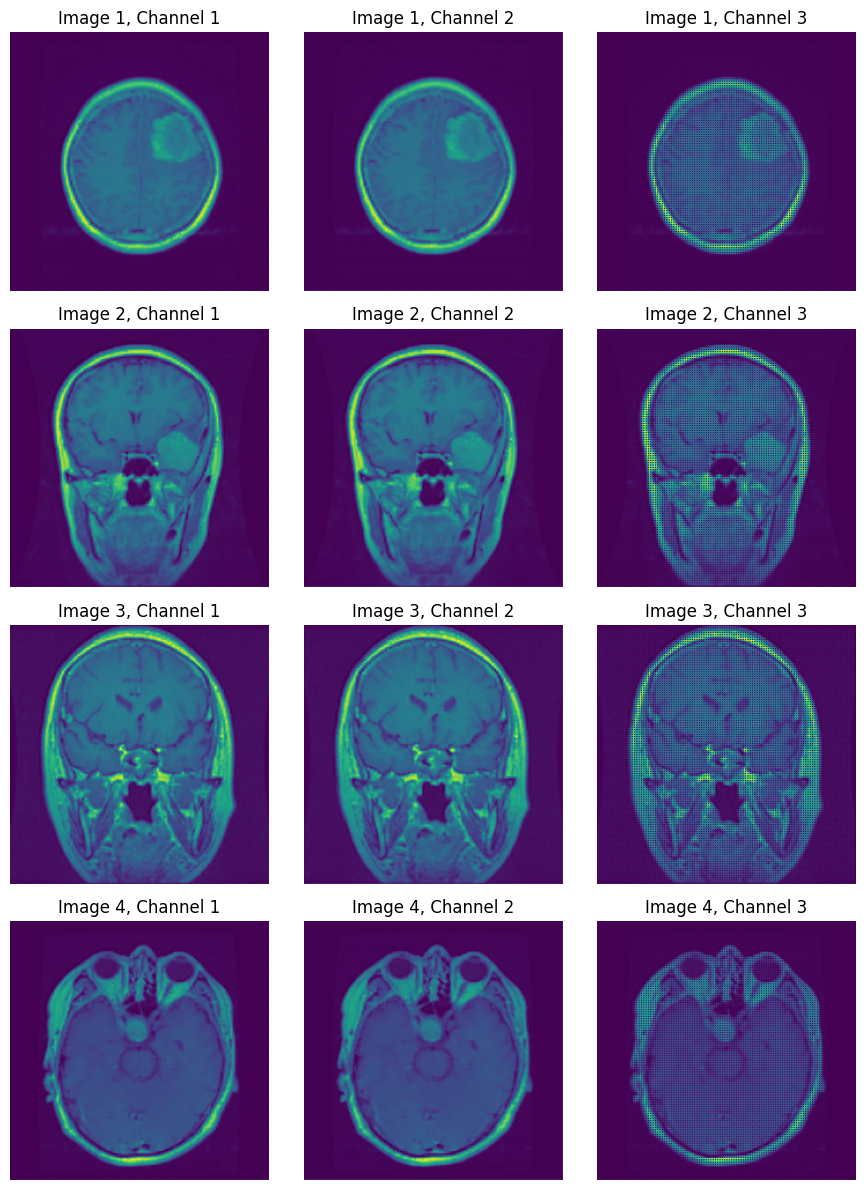

In [26]:
plot_4d_tensor(h2_features, num_images=4, num_channels=3)

Text(0.5, 1.0, 'Autoencoder layer 2 Loss')

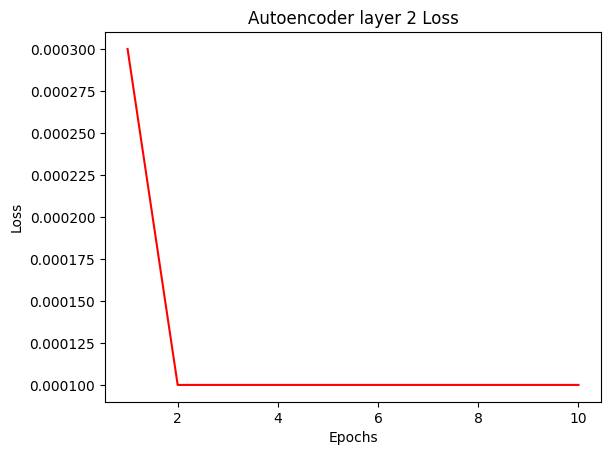

In [27]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
losses = [0.0003, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
plt.plot(epochs, losses, linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder layer 2 Loss')

In [29]:
autoencoder_2.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
  )
)

In [30]:
for criteria in [0.0001,0.0003,0.001,0.003,0.01,0.03,0.1]:
    y_pred=[]
    y_true=[]  
    test_loss = 0.0
    with torch.no_grad():
        for data in loaded_test:
            img, label = data
            img = Variable(img).to(device)
            test_outputs = autoencoder_2(img)
            loss = criterion_1_4(test_outputs, img)
            test_loss += loss.item()
            for i in range(len(img)):
                lossi=criterion_1_4(test_outputs[i], img[i])
                y_pred+=[int(lossi.item()>criteria)] #true(big loss)=1,false(small loss)=0
                y_true+=[int(label[i]>0)] #true(not normal)=1,false(normal)=0
    print('test_loss',test_loss)
    print('criteria: lossi.item()>',criteria)
    print(classification_report(y_true, y_pred, target_names=['Normal','Abnormal'], digits=4))

test_loss 0.07948294933885336
criteria: lossi.item()> 0.0001


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.07948294933885336
criteria: lossi.item()> 0.0003


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.07948294933885336
criteria: lossi.item()> 0.001


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.07948294933885336
criteria: lossi.item()> 0.003
              precision    recall  f1-score   support

      Normal     0.0943    0.0247    0.0391       405
    Abnormal     0.6722    0.8940    0.7674       906

    accuracy                         0.6255      1311
   macro avg     0.3833    0.4594    0.4033      1311
weighted avg     0.4937    0.6255    0.5424      1311

test_loss 0.07948294933885336
criteria: lossi.item()> 0.01
              precision    recall  f1-score   support

      Normal     0.2154    0.5605    0.3112       405
    Abnormal     0.3074    0.0872    0.1359       906

    accuracy                         0.2334      1311
   macro 

e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [8]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(##64 takes too much memory
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
autoencoder_3 = Autoencoder3().to(device)
criterion_1_4 = nn.MSELoss()
optimizer = optim.Adam(autoencoder_3.parameters(), lr=0.001)

In [10]:
for epoch in range(10):  ##training 10 epochs due to response issues and time limit issues
    running_loss = 0.0
    for data in loaded_train:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder_3(img)
        loss = criterion_1_4(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_dataset)))

: 

In [ ]:
class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(##128 takes too much memory
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            #nn.LocalResponseNorm(hidden_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [38]:
class Autoencoder5(nn.Module):  ###Dense Autoencoder With Softmax
    def __init__(self):
        super(Autoencoder5, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(6272, 5),  ##change 6272 to 512 or 1024  #input_size, hidden_size
            nn.ReLU(),
            nn.Linear(5, 128), #hidden_size, code_size
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 5), #code_size, hidden_size
            nn.ReLU(),
            nn.Linear(5, 4), #hidden_size, num_classes
            nn.Softmax(4)  # Softmax layer along the feature dimension
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
autoencoder_5 = Autoencoder5().to(device)
criterion_5 = nn.CrossEntropyLoss()
optimizer = optim.Adam(autoencoder_5.parameters(), lr=0.001)

In [40]:
for epoch in range(10):  ##training 10 epochs due to response issues and time limit issues
    running_loss = 0.0
    for data in loaded_train:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder_5(img)
        loss = criterion_5(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_dataset)))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (86016x224 and 6272x5)

### Some experiments with Stacked Autencoder Implementation

#### 1- Try AI solution, similar to creating different objects in a single Stacked autoencoder class

#### MAIN ISSUE IS WITH AMBIGUOUS OR UNKNOWN PARAMETERS

In [34]:
###TRY STACKED AUTOENCODER IN A SINGLE CLASS
class StackedAutoencoder(nn.Module):
    def __init__(self, num_classes = 4):#, code_size, num_classes):
        super(StackedAutoencoder, self).__init__()
        # Encoder
        encoder_layers = []
        prev_size = 224
        hidden_size=5
        for hidden_size in range(0,5):
            encoder_layers.append(nn.Conv2d(3, 16, kernel_size=3, padding=1))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            encoder_layers.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            encoder_layers.append(nn.Linear(prev_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            prev_size = hidden_size
        encoder_layers.append(nn.Linear(prev_size))#, code_size=128))
        encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        prev_size = 224#code_size
        for hidden_size in reversed(range(0,5)):
            decoder_layers.append(nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(prev_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            prev_size = hidden_size
        decoder_layers.append(nn.Linear(prev_size, num_classes))
        decoder_layers.append(nn.Softmax(dim=1))  # Softmax layer along the class dimension
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [35]:
stacked_autoencoder = StackedAutoencoder(4).to(device)
criterion_5 = nn.CrossEntropyLoss()
optimizer = optim.Adam(stacked_autoencoder.parameters(), lr=0.001)

e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


TypeError: Linear.__init__() missing 1 required positional argument: 'out_features'

### Some experiments with Stacked Autencoder Implementation

#### 2- Try to write the encoder as a combination of all the layers required
#### For example encoder 1 required first Conv layer then encoder 2 required second Conv layer
#### Just stack all layers as if in one singleton encoder

In [4]:
class StackedAutoencoder(nn.Module):
    def __init__(self):
        super(StackedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),#3,16
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),#16,32
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),#32,64
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),#64,128
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        '''self.flatten = nn.Flatten()
        
        self.dense_layers = nn.Sequential(
            nn.Linear(6727, 224),  # Adjust the input size based on the output of the encoder
            nn.ReLU(),
            nn.Linear(224, 4),
            nn.Softmax(dim=1)  # Softmax layer along the class dimension
        )'''

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use Sigmoid to ensure output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        #encoded = x
        #x = self.flatten(x)
        #x = self.dense_layers(x)
        #x = encoded.view(encoded.size(0), 128, 4, 4)  # Reshape to match the decoder input
        x = self.decoder(x)
        return x

In [42]:
model = StackedAutoencoder()  ##num_classes set to 4 in the class
print(model)

StackedAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4, bias=True)
    (3): Softmax(dim=1)
  )
  (dec

In [5]:
stacked_autoencoder = StackedAutoencoder().to(device)
criterion_5 = nn.CrossEntropyLoss()
criterion_1_4 = nn.MSELoss()
optimizer = optim.Adam(stacked_autoencoder.parameters(), lr=0.001)

In [6]:
for epoch in range(10):  ##training 10 epochs due to response issues and time limit issues
    running_loss = 0.0
    for data in loaded_train:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = stacked_autoencoder(img)
        loss = criterion_1_4(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_dataset)))

Epoch [1], Loss: 0.0006
Epoch [2], Loss: 0.0002
Epoch [3], Loss: 0.0001
Epoch [4], Loss: 0.0001
Epoch [5], Loss: 0.0001
Epoch [6], Loss: 0.0001
Epoch [7], Loss: 0.0001
Epoch [8], Loss: 0.0001
Epoch [9], Loss: 0.0001
Epoch [10], Loss: 0.0001


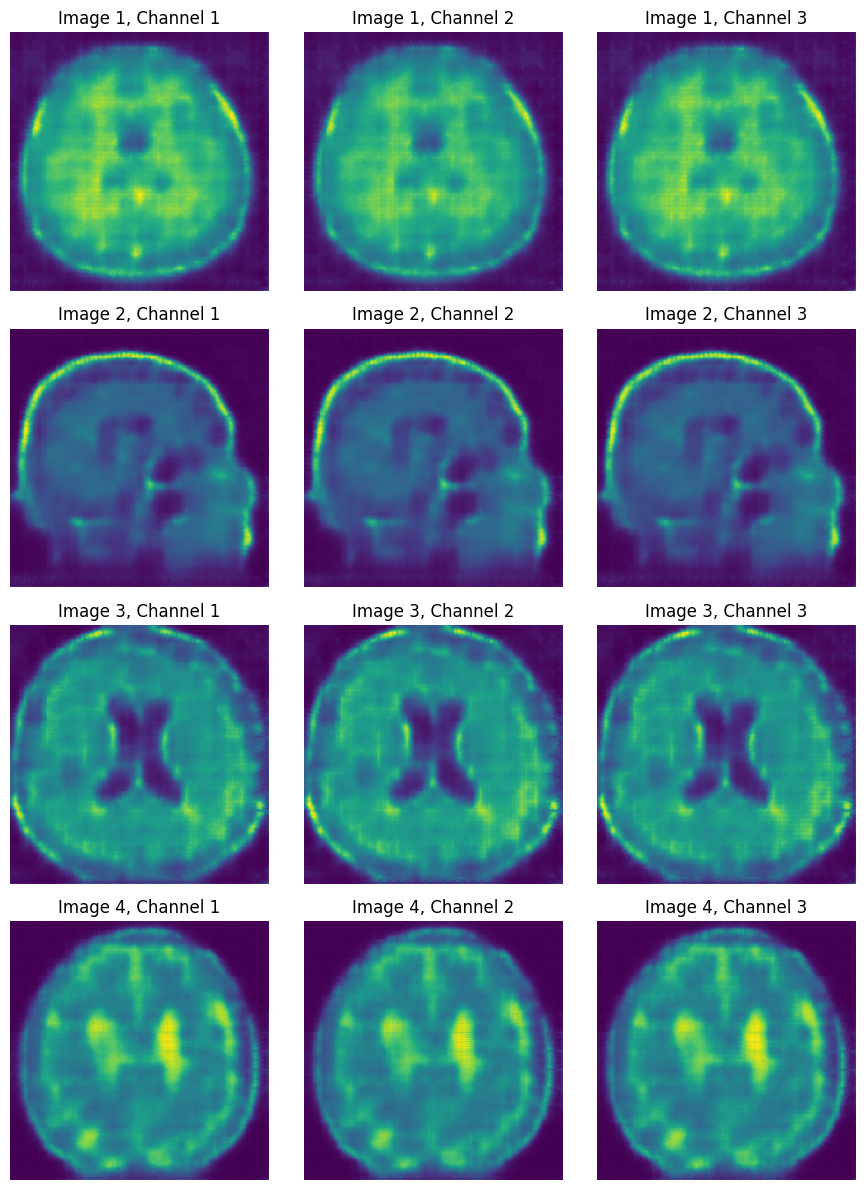

In [9]:
h4_features = outputs
plot_4d_tensor(h4_features, num_images=4, num_channels=3)

Text(0.5, 1.0, 'Autoencoder 4 Layers Loss')

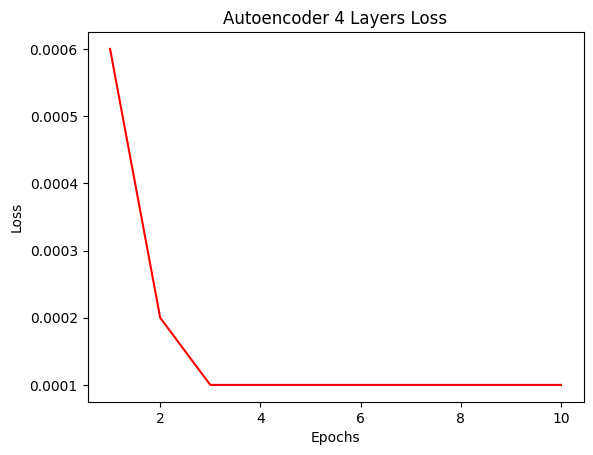

In [10]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
losses = [0.0006, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
plt.plot(epochs, losses, linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder 4 Layers Loss')

In [11]:
stacked_autoencoder.eval()

StackedAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(

In [13]:
from sklearn.metrics import classification_report
for criteria in [0.0001,0.0003,0.001,0.003,0.01,0.03,0.1]:
    y_pred=[]
    y_true=[]  
    test_loss = 0.0
    with torch.no_grad():
        for data in loaded_test:
            img, label = data
            img = Variable(img).to(device)
            test_outputs = stacked_autoencoder(img)
            loss = criterion_1_4(test_outputs, img)
            test_loss += loss.item()
            for i in range(len(img)):
                lossi=criterion_1_4(test_outputs[i], img[i])
                y_pred+=[int(lossi.item()>criteria)] #true(big loss)=1,false(small loss)=0
                y_true+=[int(label[i]>0)] #true(not normal)=1,false(normal)=0
    print('test_loss',test_loss)
    print('criteria: lossi.item()>',criteria)
    print(classification_report(y_true, y_pred, target_names=['Normal','Abnormal'], digits=4))

test_loss 0.07237243629060686
criteria: lossi.item()> 0.0001


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.07237243629060686
criteria: lossi.item()> 0.0003


e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311

test_loss 0.07237243629060686
criteria: lossi.item()> 0.001
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       405
    Abnormal     0.6911    1.0000    0.8173       906

    accuracy                         0.6911      1311
   macro avg     0.3455    0.5000    0.4087      1311
weighted avg     0.4776    0.6911    0.5648      1311



e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

test_loss 0.07237243629060686
criteria: lossi.item()> 0.003
              precision    recall  f1-score   support

      Normal     0.0459    0.0222    0.0300       405
    Abnormal     0.6448    0.7936    0.7115       906

    accuracy                         0.5553      1311
   macro avg     0.3454    0.4079    0.3707      1311
weighted avg     0.4598    0.5553    0.5010      1311

test_loss 0.07237243629060686
criteria: lossi.item()> 0.01
              precision    recall  f1-score   support

      Normal     0.2169    0.5827    0.3161       405
    Abnormal     0.2422    0.0596    0.0957       906

    accuracy                         0.2212      1311
   macro avg     0.2295    0.3212    0.2059      1311
weighted avg     0.2344    0.2212    0.1638      1311

test_loss 0.07237243629060686
criteria: lossi.item()> 0.03
              precision    recall  f1-score   support

      Normal     0.3006    0.9605    0.4579       405
    Abnormal     0.0588    0.0011    0.0022       906

    

e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\VSprojects\Brain_Tumour_Autoencoder\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [14]:
torch.save(stacked_autoencoder.state_dict(), 'stacked_auto.pth')
print("4 layer autoencoder saved successfully.")

4 layer autoencoder saved successfully.
